In [1]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [2]:
X, Y = make_classification(n_samples=4000, n_features=50, n_informative=3, n_redundant=47,
                           n_classes=2, n_clusters_per_class=3, random_state=1)
(X.shape, Y.shape)

((4000, 50), (4000,))

In [3]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [4]:
model = SVC(probability=True)
model.fit(X_train, Y_train)
print(f'Accuracy = {model.score(X_test, Y_test)}')
predictions = model.predict_proba(X_test)

Accuracy = 0.859


In [5]:
predictions

array([[0.28046984, 0.71953016],
       [0.08465102, 0.91534898],
       [0.8719918 , 0.1280082 ],
       ...,
       [0.14355458, 0.85644542],
       [0.77565257, 0.22434743],
       [0.07358063, 0.92641937]])

In [6]:
number_bins = 10
bins = np.linspace(0, 1, number_bins + 1)
bin_midpoints = np.empty(number_bins)
for i in range(number_bins):
    bin_midpoints[i] = np.mean((bins[i], bins[i + 1]))
# Take the values for the class label 1.
predictions_binned = np.digitize(predictions[:, 1], bins, right=True)

In [7]:
observed_1s = np.empty(number_bins)
prob_pred = np.empty(number_bins)
for i, predicted_bin in enumerate(range(1, number_bins + 1)):
    # Find predictions in the specific bin.
    bin_mask = predictions_binned == predicted_bin
    # Now find out how many of observations in that bin belong to the first class.
    real = Y_test[bin_mask]
    # The first class in the model.predict is class 0 in df.
    ones = np.sum(real == 1)
    zeros = np.sum(real == 0)
    observed_1s_percent = ones / (ones + zeros)
    observed_1s[i] = observed_1s_percent
    # Calculate mean probability from predictions in a bin.
    prob_pred[i] = np.mean(predictions[:, 1][bin_mask])
(observed_1s, prob_pred)

(array([0.044     , 0.09848485, 0.35      , 0.25806452, 0.46875   ,
        0.525     , 0.8       , 0.79207921, 0.89686099, 0.90517241]),
 array([0.05187062, 0.13817672, 0.24294352, 0.35880058, 0.45074363,
        0.55986901, 0.65651909, 0.75937985, 0.85875583, 0.92379363]))

In [8]:
calibration_curve(y_true=Y_test, y_prob=predictions[:, 1], n_bins=number_bins)

(array([0.044     , 0.09848485, 0.35      , 0.25806452, 0.46875   ,
        0.525     , 0.8       , 0.79207921, 0.89686099, 0.90517241]),
 array([0.05187062, 0.13817672, 0.24294352, 0.35880058, 0.45074363,
        0.55986901, 0.65651909, 0.75937985, 0.85875583, 0.92379363]))

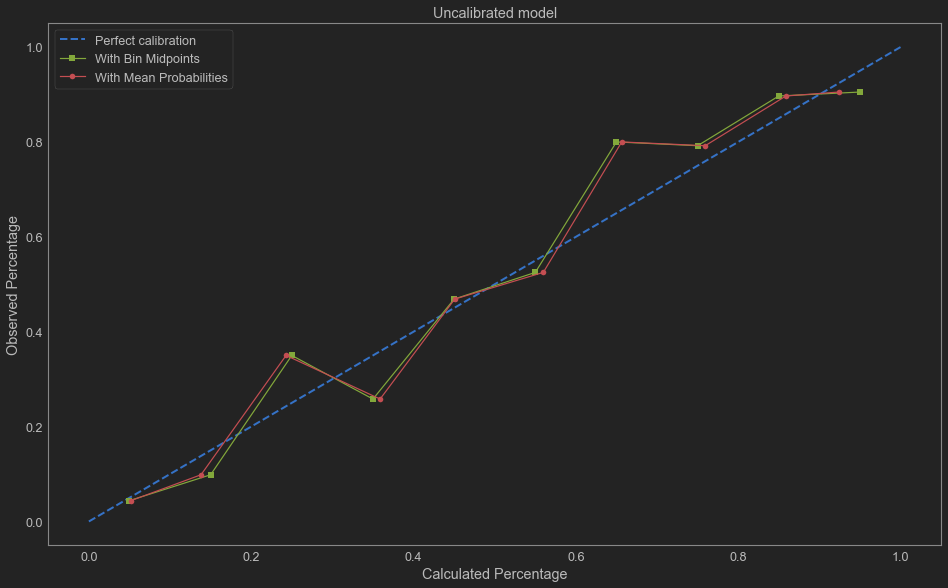

In [9]:
def calibration_plot(x1, y1, label1, x2, y2, label2, title):
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=2, label='Perfect calibration')
    plt.plot(x1, y1, marker='s', label=label1)
    plt.plot(x2, y2, marker='o', label=label2)
    plt.xlabel('Calculated Percentage')
    plt.ylabel('Observed Percentage')
    plt.title(title)
    plt.legend();

calibration_plot(x1=bin_midpoints, y1=observed_1s, x2=prob_pred, y2=observed_1s,
                 label1='With Bin Midpoints', label2='With Mean Probabilities', title='Uncalibrated model')

## Using an already fitted model.

In [10]:
calibrated_prefit_sig = CalibratedClassifierCV(base_estimator=model, method='sigmoid')#, cv='prefit')
calibrated_prefit_sig.fit(X_test, Y_test)
print(f'Accuracy = {calibrated_prefit_sig.score(X_test, Y_test)}')
predictions_prefit_sig = calibrated_prefit_sig.predict_proba(X_test)

Accuracy = 0.85


In [11]:
calibrated_prefit_iso = CalibratedClassifierCV(base_estimator=model, method='isotonic')#, cv='prefit')
calibrated_prefit_iso.fit(X_test, Y_test)
print(f'Accuracy = {calibrated_prefit_iso.score(X_test, Y_test)}')
predictions_prefit_iso = calibrated_prefit_iso.predict_proba(X_test)

Accuracy = 0.859


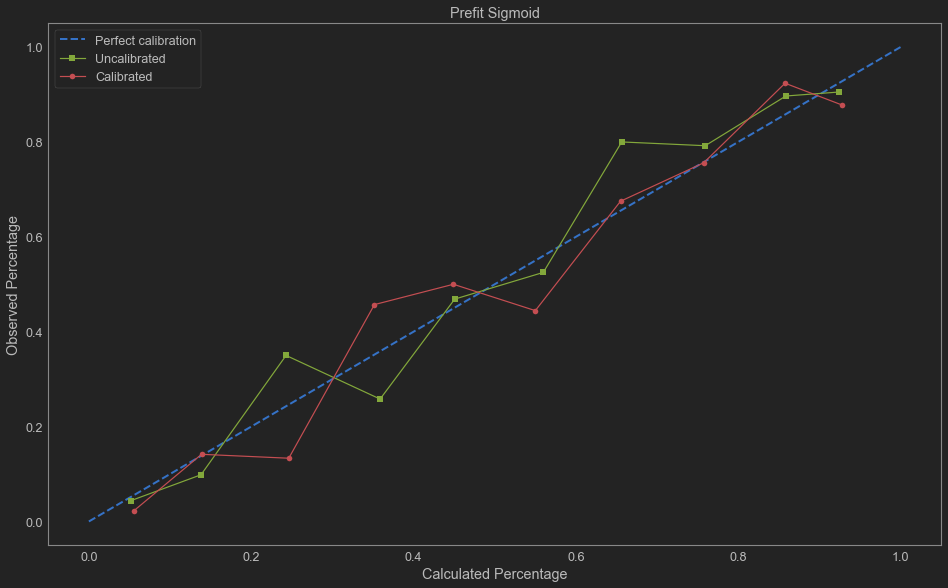

In [12]:
true, pred = calibration_curve(Y_test, predictions_prefit_sig[:, 1], n_bins=number_bins)
calibration_plot(x1=prob_pred, y1=observed_1s, label1='Uncalibrated',
                 x2=pred, y2=true, label2='Calibrated', title='Prefit Sigmoid')

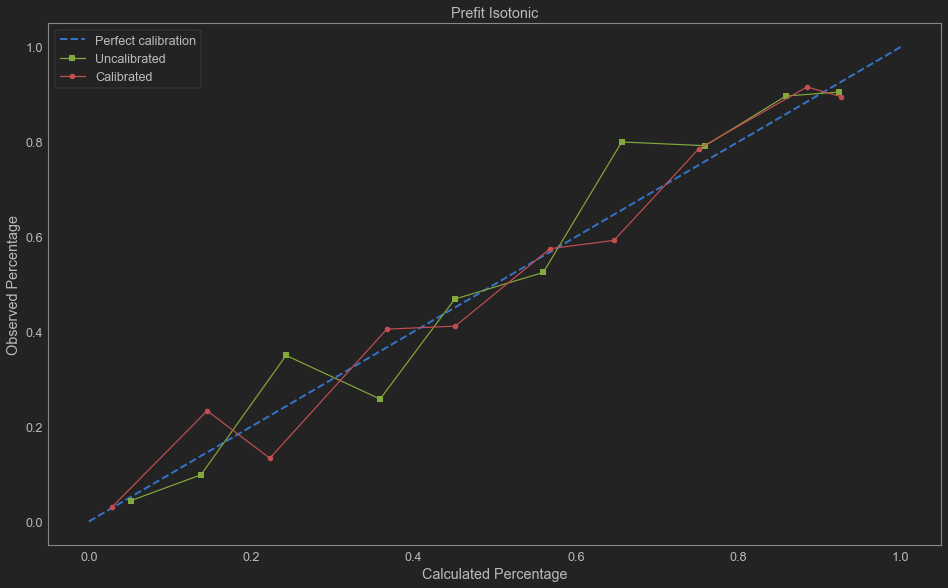

In [13]:
true, pred = calibration_curve(Y_test, predictions_prefit_iso[:, 1], n_bins=number_bins)
calibration_plot(x1=prob_pred, y1=observed_1s, label1='Uncalibrated',
                 x2=pred, y2=true, label2='Calibrated', title='Prefit Isotonic')

## Using a model that was not fitted before.

In [14]:
calibrated_nofit_sig = CalibratedClassifierCV(base_estimator=SVC(), method='sigmoid')
calibrated_nofit_sig.fit(X_train, Y_train)
print(f'Accuracy = {calibrated_nofit_sig.score(X_test, Y_test)}')
predictions_nofit_sig = calibrated_nofit_sig.predict_proba(X_test)

Accuracy = 0.858


In [15]:
calibrated_nofit_iso = CalibratedClassifierCV(base_estimator=SVC(), method='isotonic')
calibrated_nofit_iso.fit(X_train, Y_train)
print(f'Accuracy = {calibrated_nofit_iso.score(X_test, Y_test)}')
predictions_nofit_iso = calibrated_nofit_iso.predict_proba(X_test)

Accuracy = 0.86


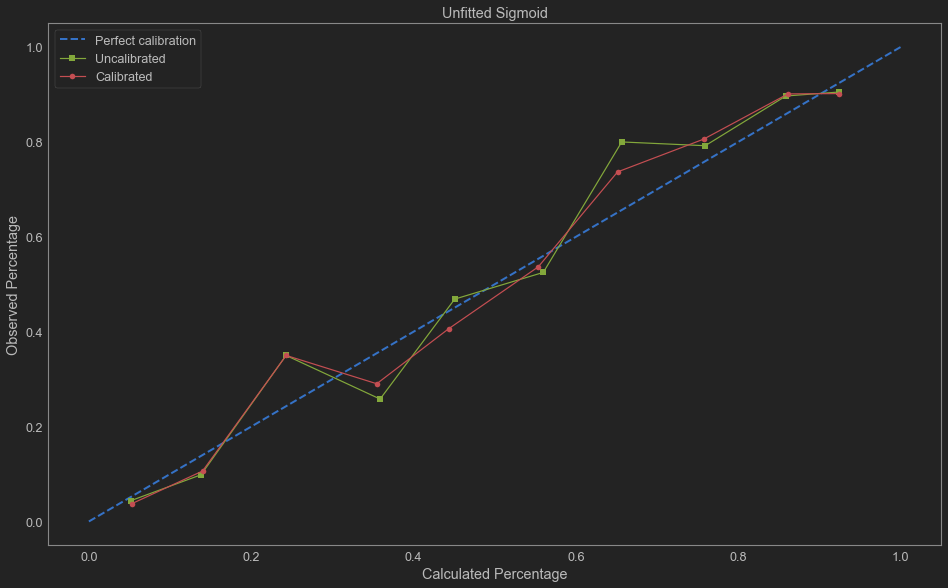

In [16]:
true, pred = calibration_curve(Y_test, predictions_nofit_sig[:, 1], n_bins=number_bins)
calibration_plot(x1=prob_pred, y1=observed_1s, label1='Uncalibrated',
                 x2=pred, y2=true, label2='Calibrated', title='Unfitted Sigmoid')

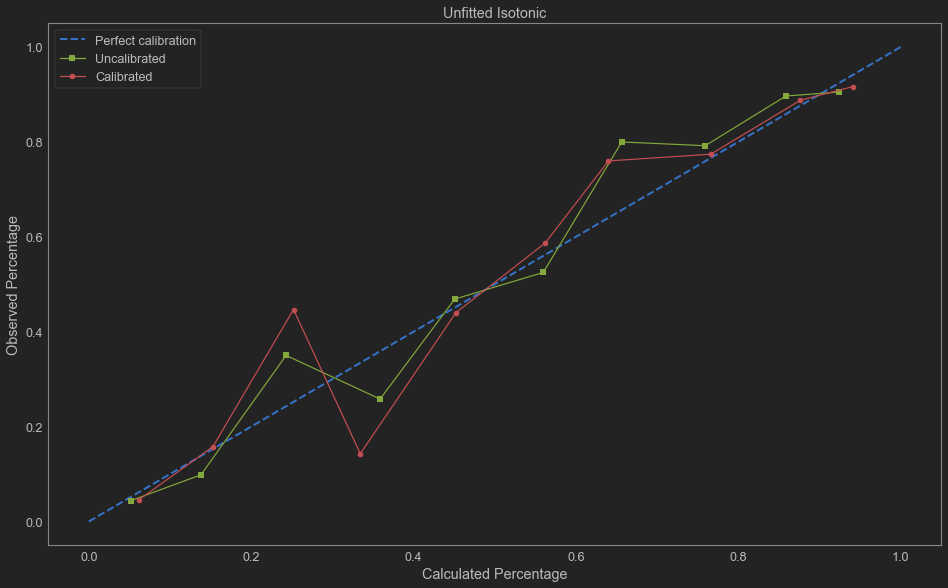

In [17]:
true, pred = calibration_curve(Y_test, predictions_nofit_iso[:, 1], n_bins=number_bins)
calibration_plot(x1=prob_pred, y1=observed_1s, label1='Uncalibrated',
                 x2=pred, y2=true, label2='Calibrated', title='Unfitted Isotonic')

# Presenting class Probabilities

Text(0.05, 0.5, 'Count')

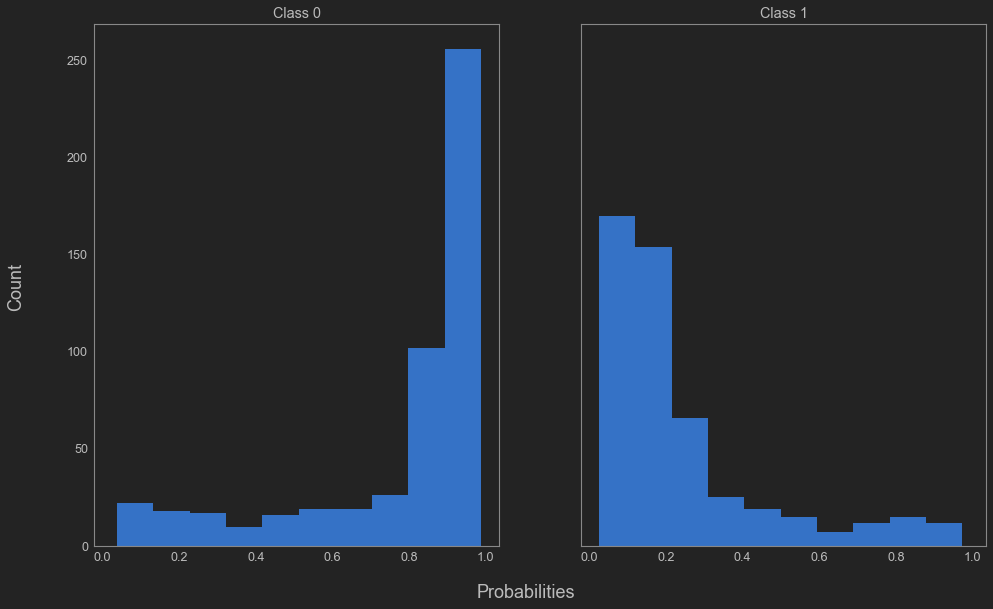

In [48]:
class_mask = Y_test == 0
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
ax1.hist(predictions[class_mask][:, 0])
ax2.hist(predictions[~class_mask][:, 0])
ax1.set_title('Class 0')
ax2.set_title('Class 1')
fig.text(0.5, 0.05, 'Probabilities', ha='center', fontsize=18)
fig.text(0.05, 0.5, 'Count', va='center', rotation='vertical', fontsize=18)